# Génération de la Frontière Efficiente de Markowitz

Ce notebook illustre l'utilisation de la méthode de scalarisation pour approximer la frontière efficiente d'un portefeuille d'actions.


In [1]:
import matplotlib.pyplot as plt
from scipy.constants import sigma
from scipy.optimize import minimize
import os

from level1.functions import *

# Charger les données
df = load_datas()

In [2]:
df

,AAPL,MSFT,NVDA,AVGO,AMD,INTC,QCOM,TXN,MU,ORCL,...,WELL,EQIX,NEE,DUK,SO,D,AEP,EXC,SRE,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,24.237551,39.858452,0.483011,7.574805,2.670000,27.896456,54.334965,39.557961,33.919159,37.583096,...,50.148033,175.042175,20.032854,53.362503,30.940655,48.503338,41.371323,18.123077,39.801846,25.736328
2015-01-05,23.554743,39.491917,0.474853,7.453719,2.660000,27.581890,54.078941,38.944031,32.972347,37.056026,...,50.767132,173.242676,19.820677,52.594280,30.809046,47.914963,40.762413,17.606932,39.073910,25.444193
2015-01-06,23.556961,38.912285,0.460456,7.284193,2.630000,27.067841,53.310867,38.300522,32.084106,36.673492,...,51.490509,169.466080,19.897663,53.457737,31.178812,47.670856,40.985672,17.471863,38.708176,25.579569
2015-01-07,23.887274,39.406670,0.459257,7.480964,2.580000,27.635609,53.932636,38.988411,31.332521,36.681992,...,51.966248,170.022186,20.079790,53.629147,31.523489,47.864887,41.567509,17.495987,39.333118,25.800442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-26,257.853760,434.901825,139.891739,243.627960,125.059998,20.440001,155.059036,185.700836,89.446541,169.989227,...,124.210960,927.127563,70.180824,104.529358,80.157593,51.265697,88.959763,36.136345,84.832939,65.988274
2024-12-27,254.439224,427.377319,136.972519,240.043457,125.190002,20.299999,153.797272,185.168152,88.261490,167.296036,...,122.844917,921.525940,69.928688,104.558319,80.447891,51.475685,89.394615,36.117046,84.987869,65.949562


In [3]:
# Calcul des rendements logarithmiques
returns = f_returns_on_df(df)

# Calcul des paramètres pour l'optimisation
mu = f_mu_on_df(returns)  # Annualisation (252 jours boursiers)
Sigma = f_sigma_on_df(returns)  # Annualisation de la matrice de covariance
num_assets = len(mu)

# Calcul des Paramètres d'Optimisation

Les rendements logarithmiques sont calculés comme :

$  r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) $

Le vecteur des rendements moyens annualisés :

$ \mu = \frac{1}{T} \sum_{t=1}^T r_t \times 252 $

La matrice de covariance annualisée :

$ \Sigma = \frac{1}{T} \sum_{t=1}^T (r_t - \bar{r})(r_t - \bar{r})^T \times 252 $


# Méthode de résolution par scalarisation pour générer la frontière efficiente

Fonction rendement : $ F_1(w) = - (w^T \mu) $

Fonction risque : $ F_2(w) = w^T \Sigma w $

Fonction objectif scalarisée : $ F(w) = \lambda \cdot (w^T \Sigma w) - (1 - \lambda) \cdot (w^T \mu) $

In [4]:
lambdas = np.linspace(0, 1, 100)  # 100 points entre 0 et 1
frontier_yields, frontier_volatility, frontier_weights = optimize_portfolio(lambdas, mu, Sigma)

# Génération de la Frontière Efficiente

En faisant varier $ \lambda\ $ de 0 à 1, nous obtenons différents portefeuilles optimaux.


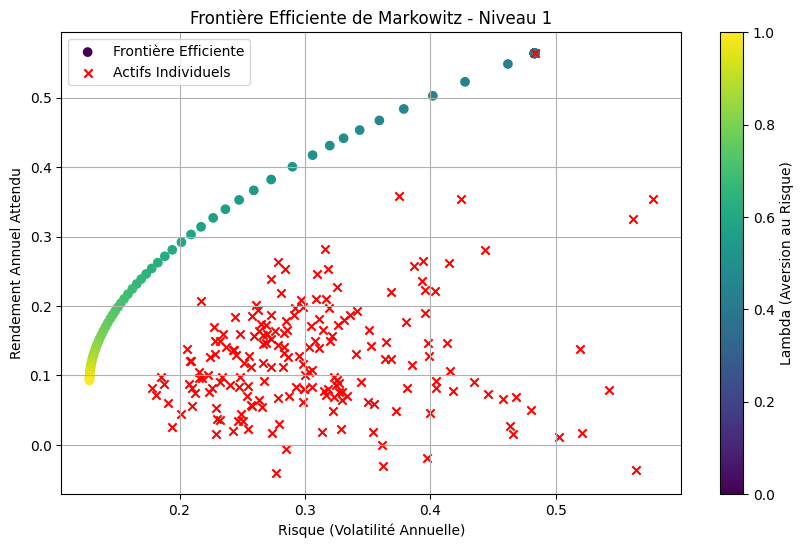

In [5]:
# Tracer la frontière efficiente
plt.figure(figsize=(10, 6))
plt.scatter(frontier_volatility, frontier_yields, c=lambdas, cmap='viridis', label='Frontière Efficiente')
plt.scatter(np.sqrt(np.diag(Sigma)), mu, c='red', marker='x', label='Actifs Individuels')
plt.colorbar(label='Lambda (Aversion au Risque)')
plt.xlabel('Risque (Volatilité Annuelle)')
plt.ylabel('Rendement Annuel Attendu')
plt.title('Frontière Efficiente de Markowitz - Niveau 1')
plt.grid(True)
plt.legend()
plt.show()

In [6]:
print("Le portefeuille avec le rendement le plus élevé :")
max_return_index = np.argmax(frontier_yields)
print(f"Rendement : {frontier_yields[max_return_index]:.4f}, Volatilité : {frontier_volatility[max_return_index]:.4f}")
weights = frontier_weights[max_return_index]
weights[weights < 1e-4] = 0  # Nettoyer les poids très faibles pour l'affichage
print(f"Actifs sélectionnés :")
for i, weight in enumerate(weights):
    if weight > 0:
        print(f"  {df.columns[i]} : {weight:.4f}")
#print(f"Poids : {weights}")

print("\nLe portefeuille avec le risque le plus faible :")
min_risk_index = np.argmin(frontier_volatility)
print(f"Rendement : {frontier_yields[min_risk_index]:.4f}, Volatilité : {frontier_volatility[min_risk_index]:.4f}")
weights = frontier_weights[min_risk_index]
weights[weights < 1e-4] = 0  # Nettoyer les poids très faibles pour l'affichage
print(f"Actifs sélectionnés :")
for i, weight in enumerate(weights):
    if weight > 0:
        print(f"  {df.columns[i]} : {weight:.4f}")
#print(f"Poids : {weights}")

Le portefeuille avec le rendement le plus élevé :
Rendement : 0.5641, Volatilité : 0.4831
Actifs sélectionnés :
  NVDA : 1.0000

Le portefeuille avec le risque le plus faible :
Rendement : 0.0929, Volatilité : 0.1282
Actifs sélectionnés :
  PANW : 0.0189
  SAP : 0.0032
  TSM : 0.0347
  VZ : 0.1391
  EA : 0.0342
  TTWO : 0.0108
  AMZN : 0.0032
  MCD : 0.0431
  HLT : 0.0429
  AZO : 0.0142
  KO : 0.0402
  WMT : 0.0898
  MO : 0.0225
  KMB : 0.0057
  GIS : 0.0496
  KR : 0.0511
  CPB : 0.0527
  CHD : 0.0541
  XOM : 0.0027
  EQT : 0.0023
  JNJ : 0.0878
  PFE : 0.0189
  MRK : 0.0378
  ABBV : 0.0005
  BMY : 0.0466
  GILD : 0.0136
  LMT : 0.0298
  PSA : 0.0307
  AEP : 0.0192


In [7]:
df_theory = pd.DataFrame({
    'Volatilité': frontier_volatility,
    'Rendement': frontier_yields
})

# Sauvegarde dans un CSV
df_theory.to_csv('frontiere_theorique_markowitz.csv', index=False)
print("Frontière théorique sauvegardée !")

Frontière théorique sauvegardée !
